<a href="https://colab.research.google.com/github/manish-anandani/Data-Science-Projects/blob/main/Employee_Attrition_Prediction_using_Boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

In [2]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [3]:
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.4 MB/s eta 0:00:00


### Import Required Packages

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.ensemble import StackingClassifier
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load the Dataset

In [5]:
# read the dataset
df_emp = pd.read_csv('/content/hr_employee_attrition_train.csv')
print(df_emp.shape)
# df_emp.info()
sns.set(sns.reset_orig())

(1170, 35)


There can be more than one file to read as this is introduced as a competition, dataset has one file for training the model. Their can be other files as one containing the test features and the other can be the true labels.

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

In [6]:
df_emp.isnull().sum().sum()

0

In [7]:
# Checking columns that have only single values in them i.e, constant columns
const_cols = []
for i in df_emp.columns:
    if df_emp[i].nunique() == 1:
        const_cols.append(i)

print(const_cols)
df_emp.drop(columns=const_cols, axis=1, inplace=True)

['employeecount', 'over18', 'standardhours']


In [8]:
# print(df_emp.columns)
columns_int_to_float =['age','dailyrate','distancefromhome','employeenumber',
                       'hourlyrate','monthlyincome', 'monthlyrate','totalworkingyears','yearsatcompany',
                       'yearsincurrentrole','yearssincelastpromotion', 'yearswithcurrmanager','numcompaniesworked',
                       'percentsalaryhike']
# print(columns_int_to_float)
df_emp[columns_int_to_float] = df_emp[columns_int_to_float].astype(float)

df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1170 non-null   float64
 1   businesstravel            1170 non-null   object 
 2   dailyrate                 1170 non-null   float64
 3   department                1170 non-null   object 
 4   distancefromhome          1170 non-null   float64
 5   education                 1170 non-null   int64  
 6   educationfield            1170 non-null   object 
 7   employeenumber            1170 non-null   float64
 8   environmentsatisfaction   1170 non-null   int64  
 9   gender                    1170 non-null   object 
 10  hourlyrate                1170 non-null   float64
 11  jobinvolvement            1170 non-null   int64  
 12  joblevel                  1170 non-null   int64  
 13  jobrole                   1170 non-null   object 
 14  jobsatis

In [9]:
df_emp.drop('employeenumber',axis=1, inplace=True)

In [10]:
# Maximum categories in the cat variables
cols = df_emp.select_dtypes(include=['int','object']).columns
max_cat_vals = []
i=0
for col in cols:
  col_val_cnts = df_emp[[col]].value_counts().count()
  print(col, col_val_cnts)


businesstravel 3
department 3
education 5
educationfield 6
environmentsatisfaction 4
gender 2
jobinvolvement 4
joblevel 5
jobrole 9
jobsatisfaction 4
maritalstatus 3
overtime 2
performancerating 2
relationshipsatisfaction 4
stockoptionlevel 4
trainingtimeslastyear 7
worklifebalance 4
attrition 2


In [11]:
# Find categorical columns
obj_categorical_columns = df_emp.select_dtypes(include=['object']).columns
int_categorical_columns = df_emp.select_dtypes(include=['int']).columns
categorical_columns = obj_categorical_columns.append(int_categorical_columns)

# Find numerical columns
numerical_columns = df_emp.select_dtypes(include=['float']).columns

print("Obj Categorical columns:\n", obj_categorical_columns, len(obj_categorical_columns))
print()
print("Int Categorical columns:\n", int_categorical_columns, len(int_categorical_columns))
print()
print("Categorical columns:\n", categorical_columns, len(categorical_columns))
print()
print("Numerical columns:\n", numerical_columns, len(numerical_columns))
print()


Obj Categorical columns:
 Index(['businesstravel', 'department', 'educationfield', 'gender', 'jobrole',
       'maritalstatus', 'overtime', 'attrition'],
      dtype='object') 8

Int Categorical columns:
 Index(['education', 'environmentsatisfaction', 'jobinvolvement', 'joblevel',
       'jobsatisfaction', 'performancerating', 'relationshipsatisfaction',
       'stockoptionlevel', 'trainingtimeslastyear', 'worklifebalance'],
      dtype='object') 10

Categorical columns:
 Index(['businesstravel', 'department', 'educationfield', 'gender', 'jobrole',
       'maritalstatus', 'overtime', 'attrition', 'education',
       'environmentsatisfaction', 'jobinvolvement', 'joblevel',
       'jobsatisfaction', 'performancerating', 'relationshipsatisfaction',
       'stockoptionlevel', 'trainingtimeslastyear', 'worklifebalance'],
      dtype='object') 18

Numerical columns:
 Index(['age', 'dailyrate', 'distancefromhome', 'hourlyrate', 'monthlyincome',
       'monthlyrate', 'numcompaniesworked', 'per

First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

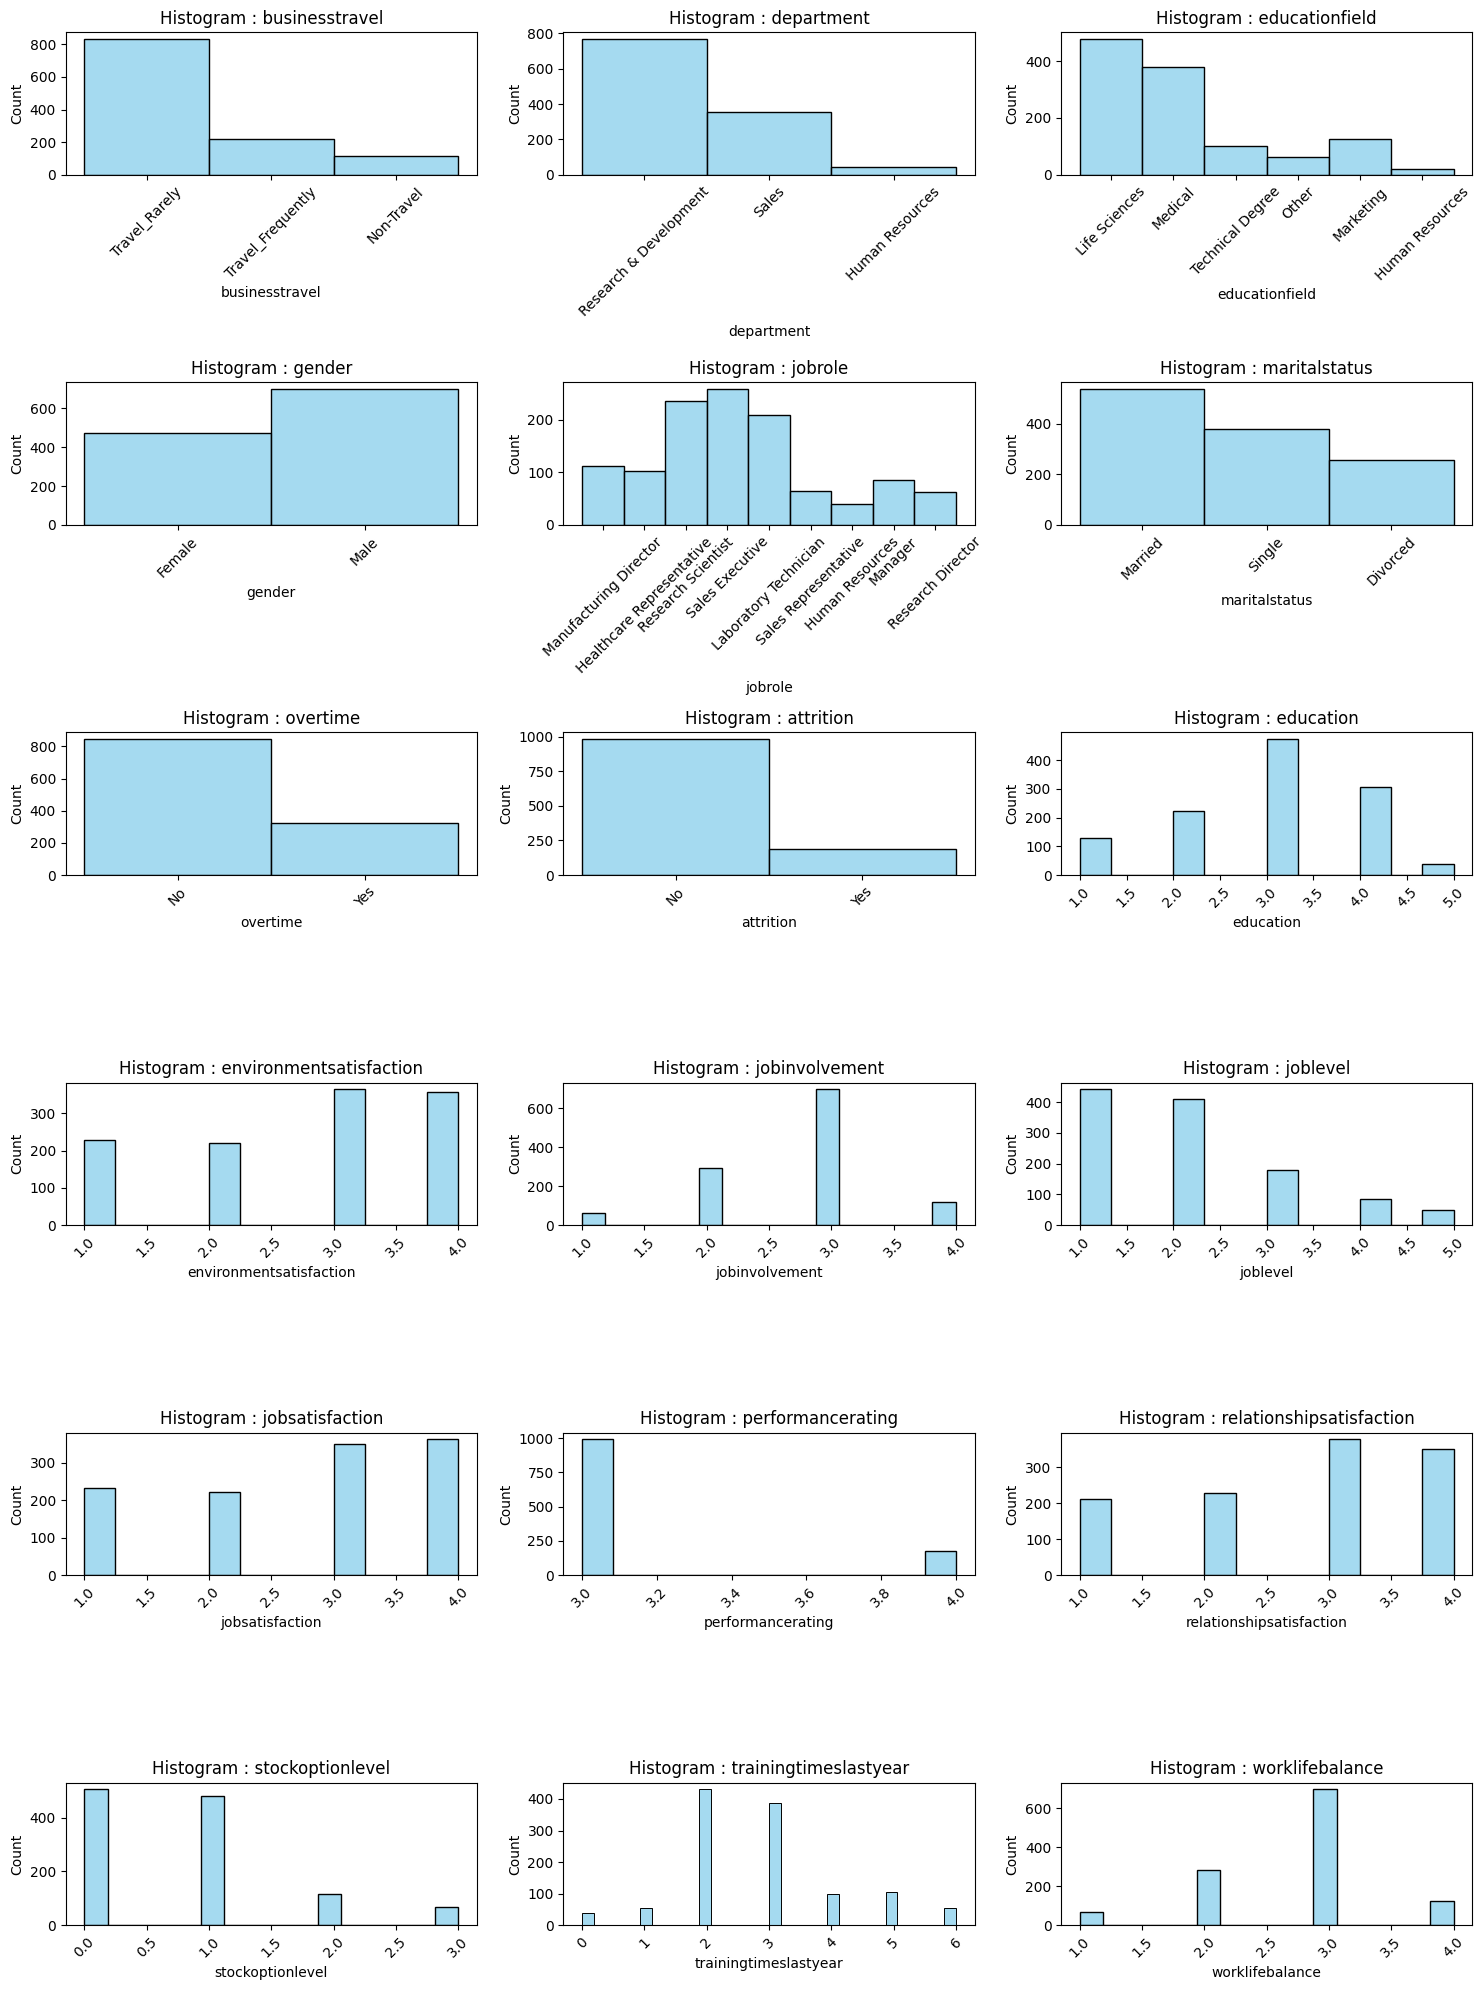

In [12]:

# Create a 6X3 grid of subplots
num_rows = 6
num_cols = 3

sns.reset_defaults()
plt.figure(figsize=(15, 20))

cnt = 0
for i in range(1, num_rows * num_cols + 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data=df_emp.loc[:,categorical_columns[cnt]], color='skyblue')
    plt.title(f'Histogram : {categorical_columns[cnt]}')
    plt.xticks(rotation=45)
    cnt=cnt+1
    if (cnt >=len(categorical_columns)):
      break

plt.tight_layout()
plt.show()

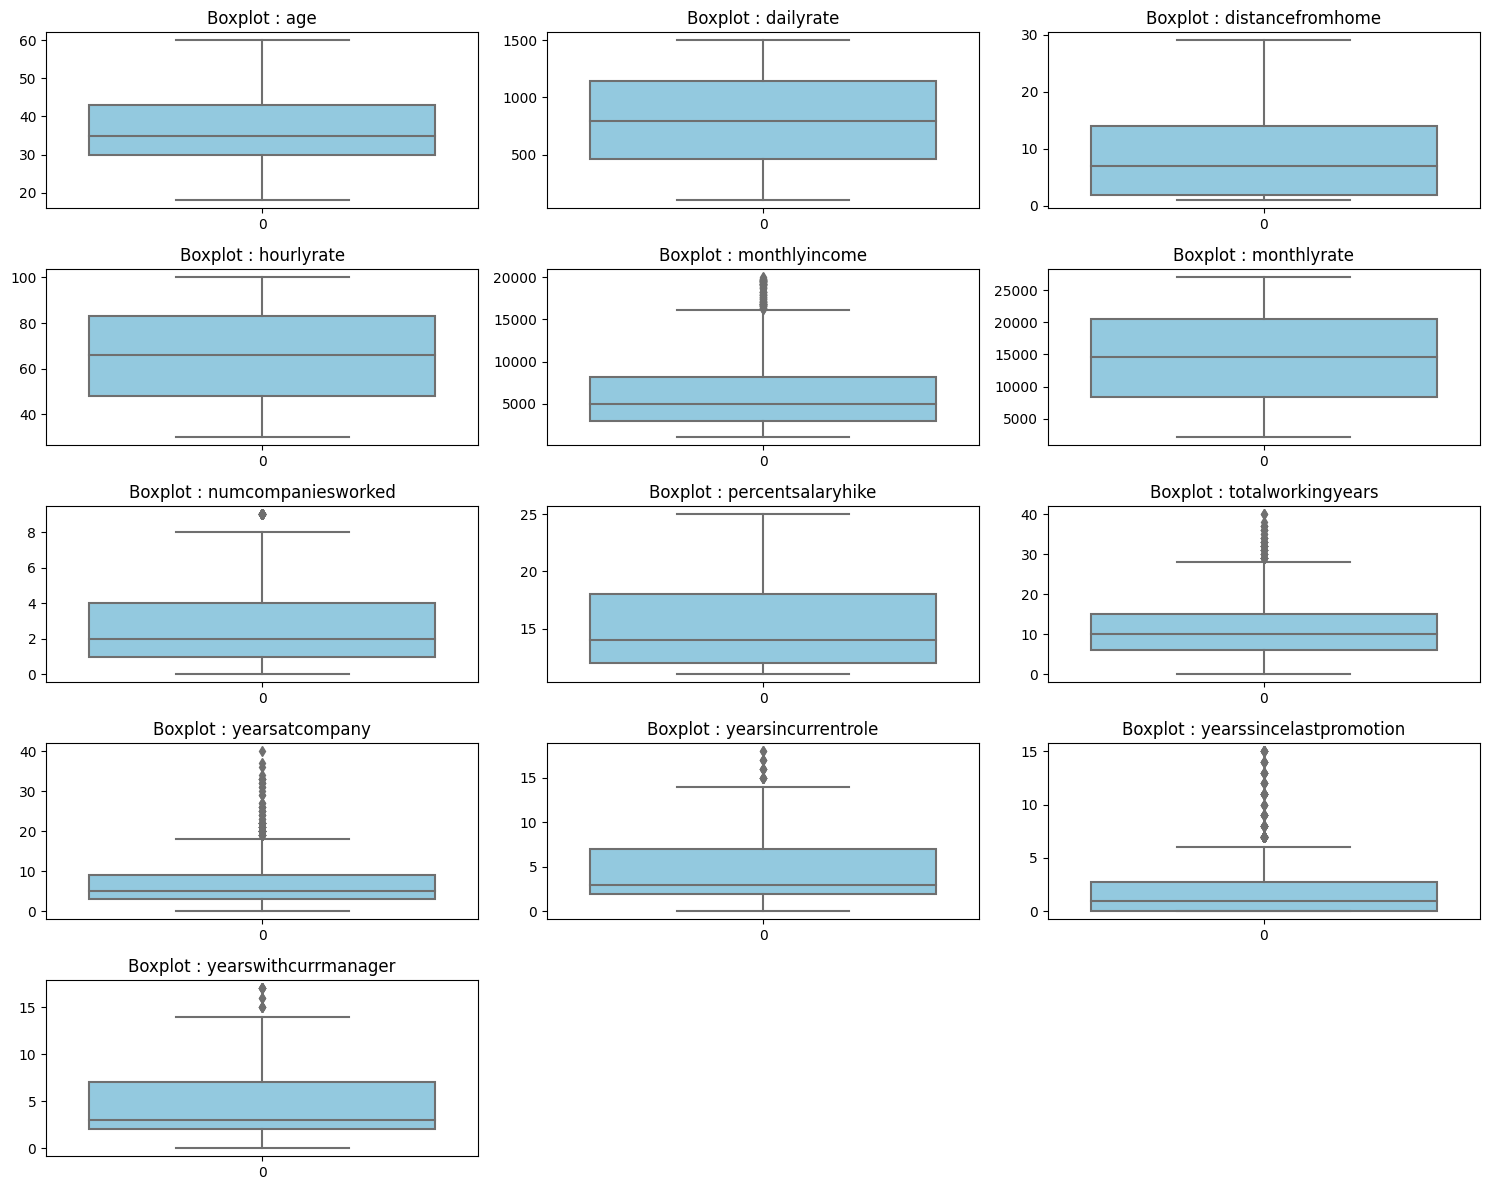

In [13]:
# Check for outliers
# Create a 5x3 grid of subplots
num_rows = 5
num_cols = 3
sns.reset_defaults()
plt.figure(figsize=(15, 12))

cnt = 0
for i in range(1, num_rows * num_cols + 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=df_emp.loc[:,numerical_columns[cnt]], color='skyblue')
    plt.title(f'Boxplot : {numerical_columns[cnt]}')
    # plt.ylim(-3, 3)  # Set y-axis limits for demonstration
    cnt=cnt+1
    if (cnt >=len(numerical_columns)):
      break

plt.tight_layout()
plt.show()

### Handling outliers

**Use lower bound as 25% and upper bound as 75% to handle the outliers

In [14]:
def update_outliers(col_name, df_temp):

  df_temp = df_temp.copy()

  # Calculate the 25th and 75th percentiles
  lower_bound = df_temp[col_name].quantile(.25)
  upper_bound = df_temp[col_name].quantile(.75)

  # Cap the lower side outliers
  df_temp[col_name] = df_temp[col_name].apply(lambda x: max(x, lower_bound))

  # Cap the upper side outliers
  df_temp[col_name] = df_temp[col_name].apply(lambda x: min(x, upper_bound))

  return df_temp

print(numerical_columns)
df_emp_clean = df_emp.copy()
for col in numerical_columns:
  df_emp_clean = update_outliers(col, df_emp_clean)

# df_emp_clean = remove_outliers('monthlyincome',df_emp)
df_emp_clean.shape

Index(['age', 'dailyrate', 'distancefromhome', 'hourlyrate', 'monthlyincome',
       'monthlyrate', 'numcompaniesworked', 'percentsalaryhike',
       'totalworkingyears', 'yearsatcompany', 'yearsincurrentrole',
       'yearssincelastpromotion', 'yearswithcurrmanager'],
      dtype='object')


(1170, 31)

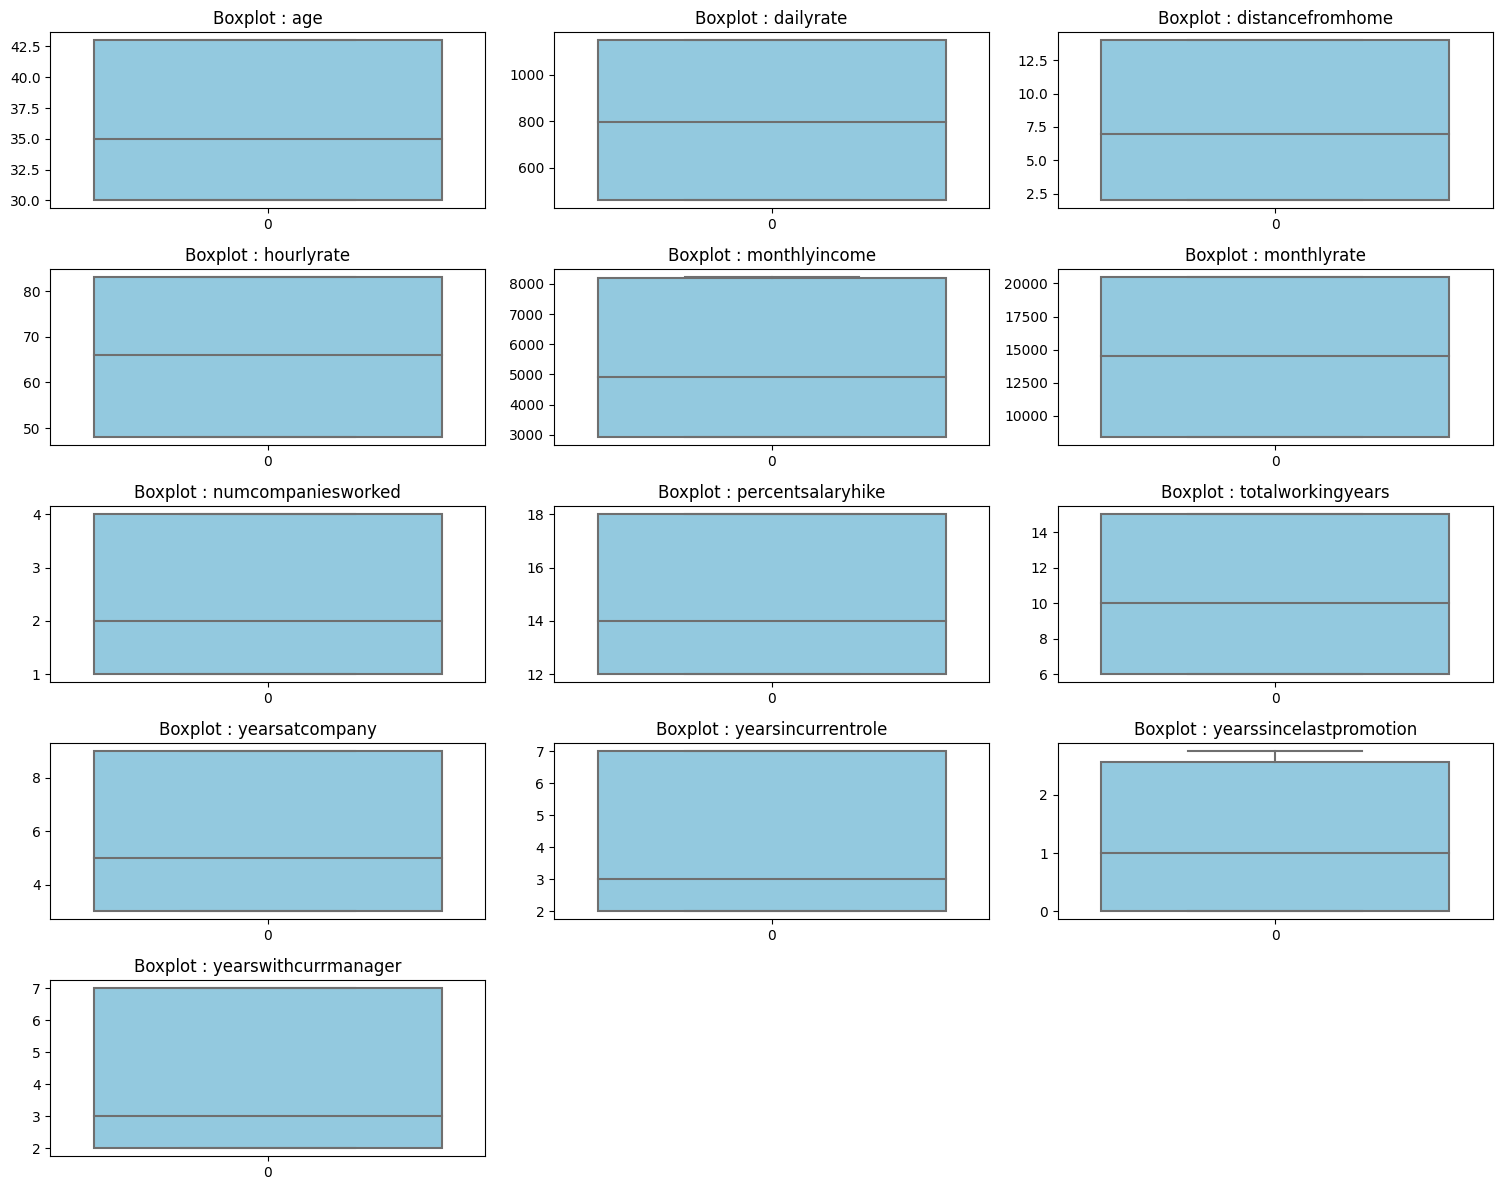

In [15]:
# Create a 5x6 grid of subplots
num_rows = 5
num_cols = 3
sns.reset_defaults()
plt.figure(figsize=(15, 12))

cnt = 0
for i in range(1, num_rows * num_cols + 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(data=df_emp_clean.loc[:,numerical_columns[cnt]], color='skyblue')
    plt.title(f'Boxplot : {numerical_columns[cnt]}')
    # plt.ylim(-3, 3)  # Set y-axis limits for demonstration
    cnt=cnt+1
    if (cnt >=len(numerical_columns)):
      break

plt.tight_layout()
plt.show()

### Target label imbalance

In [16]:
# Count of unique values in Attrition column
# YOUR CODE HERE
df_emp_clean.attrition.value_counts()

No     981
Yes    189
Name: attrition, dtype: int64

16.153846153846153 83.84615384615385


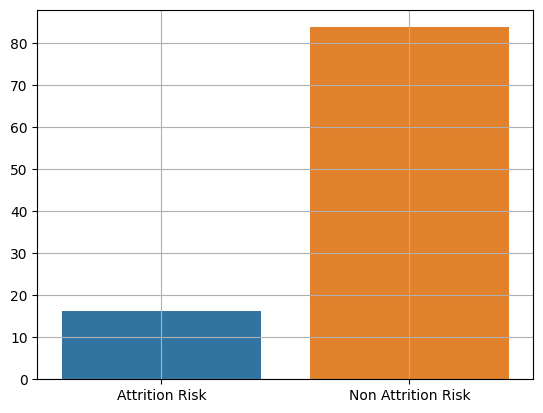

In [17]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE
tot_samples = len(df_emp_clean)
non_del_percent = list(df_emp_clean.attrition.value_counts())[0]/tot_samples*100
del_percent = list(df_emp_clean.attrition.value_counts())[1]/tot_samples*100
print(del_percent,non_del_percent)

# sns.set(style="whitegrid")
sns.barplot(x=['Attrition Risk', 'Non Attrition Risk'], y=[del_percent, non_del_percent])
# plt.yticks(np.arange(0,105,5))
plt.grid(which='both', visible=True)
plt.show()

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE - Synthetic MInority Oversampling Technique  
2. Cross Validation
3. Regularizing the model's parameters

###Plot pairplot

In [18]:
# Visualize a pairplot with relevant features
df_emp_clean_int = df_emp_clean[int_categorical_columns]
df_emp_clean_int
# sns.pairplot(df_emp_clean_numerical)


,education,environmentsatisfaction,jobinvolvement,joblevel,jobsatisfaction,performancerating,relationshipsatisfaction,stockoptionlevel,trainingtimeslastyear,worklifebalance
0,2,2,2,2,4,3,4,2,2,2
1,2,2,3,2,3,3,4,0,2,3
2,3,3,3,1,1,3,1,0,2,3
3,3,3,3,2,3,3,2,1,3,3
4,4,2,3,1,2,4,3,1,3,3
...,...,...,...,...,...,...,...,...,...,...
1165,4,3,3,2,2,3,3,1,4,4
1166,1,1,3,3,3,4,2,1,3,1
1167,3,3,3,1,2,3,3,0,2,2
1168,2,2,2,2,2,3,3,0,3,3


### Explore Correlation

- Plotting the Heatmap

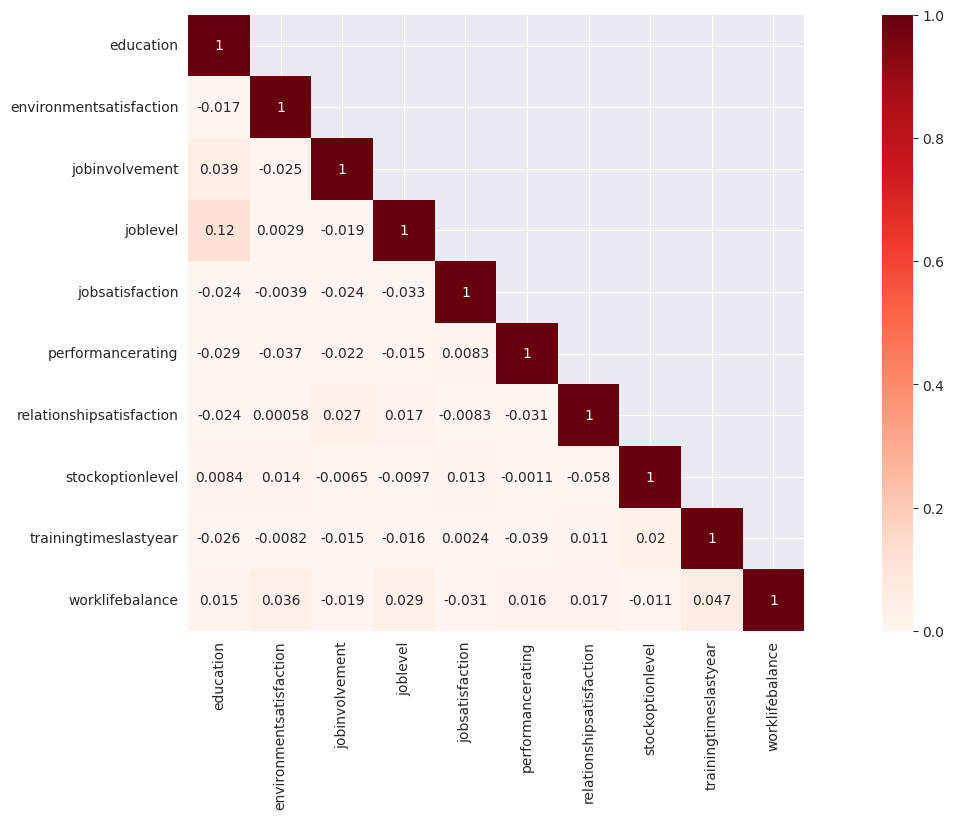

In [22]:
# Visualize heatmap
# df_emp_clean_numerical.info()
sns.set(sns.reset_orig())
matrix = df_emp_clean_int.corr()
heat = np.array(matrix)
heat[np.tril_indices_from(heat)] = False

plt.figure(figsize=(20, 8))
sns.heatmap(matrix, mask=heat,vmax=1.0, vmin=0.0, square=True,annot=True, cmap="Reds")
plt.show()

Comment on the observations made with the pairplot and heatmap

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [23]:
# YOUR CODE HERE
df_emp_clean

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43.0,Travel_Rarely,556.00,Research & Development,14.0,2,Life Sciences,2,Female,83.0,2,2,Manufacturing Director,4,Married,5906.00,20456.25,1.0,No,13.0,3,4,2,10.0,2,2,9.0,7.0,2.75,7.0,No
1,34.0,Travel_Rarely,970.00,Research & Development,8.0,2,Medical,2,Female,83.0,3,2,Healthcare Representative,3,Single,6142.00,8387.50,3.0,No,12.0,3,4,0,10.0,2,3,5.0,2.0,2.75,3.0,No
2,39.0,Travel_Rarely,461.00,Research & Development,14.0,3,Medical,3,Male,83.0,3,1,Research Scientist,1,Single,3904.00,20456.25,1.0,No,13.0,3,1,0,6.0,2,3,5.0,2.0,0.00,3.0,Yes
3,30.0,Travel_Rarely,933.00,Sales,2.0,3,Life Sciences,3,Male,57.0,3,2,Sales Executive,3,Married,5296.00,20156.00,1.0,No,17.0,3,2,1,8.0,3,3,8.0,7.0,2.75,7.0,No
4,40.0,Travel_Rarely,461.00,Research & Development,2.0,4,Life Sciences,2,Male,83.0,3,1,Laboratory Technician,2,Married,2914.75,8387.50,3.0,No,18.0,4,3,1,7.0,3,3,4.0,2.0,0.00,3.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,43.0,Non-Travel,1146.75,Research & Development,14.0,4,Technical Degree,3,Male,64.0,3,2,Research Scientist,2,Married,5467.00,8387.50,4.0,No,18.0,3,3,1,15.0,4,4,8.0,7.0,1.00,7.0,No
1166,43.0,Travel_Rarely,530.00,Sales,14.0,1,Medical,1,Female,83.0,3,3,Manager,3,Married,8215.25,20456.25,3.0,No,18.0,4,2,1,15.0,3,1,3.0,2.0,0.00,2.0,No
1167,36.0,Travel_Frequently,469.00,Research & Development,3.0,3,Technical Degree,3,Male,48.0,3,1,Research Scientist,2,Married,3692.00,9256.00,1.0,No,12.0,3,3,0,12.0,2,2,9.0,7.0,0.00,7.0,No
1168,43.0,Non-Travel,849.00,Sales,14.0,2,Life Sciences,2,Male,83.0,2,2,Sales Executive,2,Single,7991.00,20456.25,4.0,No,15.0,3,3,0,6.0,3,3,3.0,2.0,2.00,2.0,No


Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

Refer to the Additional Notebook: CatBoost parameter tuning (CDS-B4 GDrive -> Module 2 -> Assignments -> Mar 04)

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Hint:** Column containing the information on attrition will be the target column.

In [24]:
# Copy the data
df_emp_clean_CB = df_emp_clean.copy()

In [25]:
# Target Column
y = df_emp_clean_CB['attrition']
y.shape

(1170,)

In [27]:
# Feature Space
X = df_emp_clean_CB.drop('attrition', axis=1)
X.shape

(1170, 30)

In [28]:
objective_columns = X.select_dtypes(include=['object']).columns
objective_columns
X = pd.get_dummies(X, columns = objective_columns, drop_first = True)

In [29]:
le3 = LabelEncoder()
le3.fit(y)
y_transformed = le3.transform(y)
y = y_transformed

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 2)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1569, 44), (1569,), (393, 44), (393,))

In [32]:
categorical_features_indices = np.where(X_train.dtypes != float)[0]
categorical_features_indices, len(categorical_features_indices)
# use numeric values for numeric features

(array([ 3,  4,  6,  7,  8, 13, 14, 15, 17, 18, 23, 24, 25, 26, 27, 28, 29,
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 31)

### Model Definition

* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [41]:
# Create CatBoost model
# YOUR CODE HERE
best = {'depth': 6.0, 'l2_leaf_reg': 1.0, 'learning_rate': 0.31063955985427194}
model_CB = CatBoostClassifier(
                           l2_leaf_reg=int(best['l2_leaf_reg']),
                           learning_rate=best['learning_rate'],
                           depth=best['depth'],
                           iterations=500,
                           eval_metric=metrics.Accuracy(),
                           random_seed=42,
                           verbose=False,
                           loss_function=metrics.Logloss(),
                          # # one_hot_max_size = 10
                          # # early_stopping_rounds=15
                           )

In [42]:
# Model training
model_CB.fit(X_train, y_train,
          cat_features=categorical_features_indices,
          eval_set=(X_train, y_train),
          verbose=False)

### Model performance

In [45]:
# Model performance on all sets
model_CB.score(X_test, y_test)

0.9312977099236641

In [44]:
catboost_pred = model_CB.predict(X_test)
print('Classification Report for CatBoostClassifier:')
print(classification_report(y_test, catboost_pred))

Classification Report for CatBoostClassifier:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       186
           1       0.94      0.93      0.93       207

    accuracy                           0.93       393
   macro avg       0.93      0.93      0.93       393
weighted avg       0.93      0.93      0.93       393



In [46]:
cv_params = model_CB.get_params()
cv_params

{'iterations': 500,
 'learning_rate': 0.31063955985427194,
 'depth': 6.0,
 'l2_leaf_reg': 1,
 'loss_function': 'Logloss',
 'random_seed': 42,
 'verbose': False,
 'eval_metric': 'Accuracy'}

In [47]:
cv_params.update({
                  'loss_function': metrics.Logloss()
                  })
cv_params

{'iterations': 500,
 'learning_rate': 0.31063955985427194,
 'depth': 6.0,
 'l2_leaf_reg': 1,
 'loss_function': Logloss(use_weights=True [mandatory=False]),
 'random_seed': 42,
 'verbose': False,
 'eval_metric': 'Accuracy'}

In [49]:
# Pool the dataset
pool_data = Pool(X_resampled, y_resampled, cat_features= categorical_features_indices)
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

In [50]:
cv_data = cv(
             pool= pool_data,
             params= cv_params,
             fold_count= 5
             )
cv_data.head()
# try with increased fold count -

Training on fold [0/5]

bestTest = 0.9365482234
bestIteration = 103

Training on fold [1/5]

bestTest = 0.9260204082
bestIteration = 125

Training on fold [2/5]

bestTest = 0.9260204082
bestIteration = 43

Training on fold [3/5]

bestTest = 0.9030612245
bestIteration = 40

Training on fold [4/5]

bestTest = 0.9260204082
bestIteration = 36



,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.791534,0.036756,0.803512,0.016202,0.543923,0.029328,0.531230,0.017929
1,1,0.832842,0.025377,0.842633,0.006776,0.463615,0.017875,0.445041,0.014202
2,2,0.846600,0.024962,0.870030,0.009582,0.416684,0.021591,0.387225,0.009707
3,3,0.849643,0.023313,0.884175,0.004516,0.390089,0.015539,0.345674,0.006825
4,4,0.861885,0.023402,0.894877,0.002735,0.363816,0.021845,0.316681,0.004705


In [51]:
# Maximum mean test accuracy
max_mean_test_acc = np.max(cv_data['test-Accuracy-mean'])

# Index of Maximum mean test accuracy
idx = np.argmax(cv_data['test-Accuracy-mean'])

# Standard deviation of maximum mean test accuracy
std_max_mean_test_acc = cv_data['test-Accuracy-std'][idx]

# Best validation accuracy
print('Best validation accuracy score: {:.2f}±{:.2f} on step {}'.format(max_mean_test_acc, std_max_mean_test_acc, idx))

Best validation accuracy score: 0.92±0.01 on step 92


In [52]:
# Precise validation accuracy
print('Precise validation accuracy score: {}'.format(max_mean_test_acc))

Precise validation accuracy score: 0.9169040712731793


In [ ]:
# # Create params dictionary
# params = {
#     'iterations': 500,
#     'learning_rate': 0.1,
#     'eval_metric': metrics.Accuracy(),
#     'random_seed': 42,
#     'logging_level': 'Silent',
#     'use_best_model': False
# }
# # Create Pool for training set

# # Create Pool for validation set
# validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

In [ ]:
# # Create a Simple Model having 'use_best_model' = False
# model = CatBoostClassifier(**params)
# model.fit(train_pool, eval_set=validate_pool);

In [ ]:
# # Create a best_model_params by updating 'use_best_model' to True
# best_model_params = params.copy()
# best_model_params.update({'use_best_model': True})

In [ ]:
# # Create a Best Model having 'use_best_model' = True
# best_model = CatBoostClassifier(**best_model_params)
# best_model.fit(train_pool, eval_set=validate_pool);

In [ ]:
# # Accuracy score for Simple model
# pred = model.predict(X_test)
# acc = accuracy_score(y_test, pred)
# print('Simple model validation accuracy: {:.4}'.format(acc))

# Accuracy score for Best model
# best_pred = model.predict(X_test)
# best_acc = accuracy_score(y_test, best_pred)
# print('\nBest model validation accuracy: {:.4}'.format(best_acc))

In [ ]:
# import hyperopt

# def hyperopt_objective(params):
#     # Create model
#     model = CatBoostClassifier(
#                                l2_leaf_reg = int(params['l2_leaf_reg']),
#                                learning_rate = params['learning_rate'],
#                                depth = params['depth'],
#                                iterations=500,
#                                eval_metric=metrics.Accuracy(),
#                                random_seed=42,
#                                verbose=False,
#                                loss_function=metrics.Logloss()
#                                )
#     # Perform cross-validation
#     cv_data = cv(
#                  Pool(X, y_transformed, cat_features=categorical_features_indices),
#                  model.get_params(),
#                  logging_level='Silent'
#                  )
#     # Best test accuracy
#     best_accuracy = np.max(cv_data['test-Accuracy-mean'])

#     return 1 - best_accuracy          # as hyperopt minimizes

In [ ]:
# Create space over which hyperopt needs to search
# '''
#    hp.qloguniform(label, low, high, q): returns a value like round(exp(uniform(low, high)) / q) * q
#    hp.uniform(label, low, high): returns a value uniformly between low and high
# '''
# params_space = {
#                 'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
#                 'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
#                 'depth': hyperopt.hp.quniform('depth', 6, 10, 1)
#                 }

In [ ]:
# Create trials database to store all the point evaluations of the search
# trials = hyperopt.Trials()

In [ ]:
# # # Perform hyperparameter optimization
# best = hyperopt.fmin(
#                      fn= hyperopt_objective,
#                      space= params_space,
#                      algo= hyperopt.tpe.suggest,
#                      max_evals= 50,
#                      trials= trials,
#                      )

# print(f"Best params values: {best}")


# 100%|██████████| 50/50 [23:13<00:00, 27.86s/trial, best loss: 0.13474476483922349]
# Best params values: {'depth': 6.0, 'l2_leaf_reg': 1.0, 'learning_rate': 0.31063955985427194}

In [ ]:
# from sklearn import metrics
# logit_roc_auc = metrics.roc_auc_score(y_test, predictions)
# fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

In [53]:
# Get feature importances
feature_importances = model_CB.get_feature_importance(train_pool)
# Feature names
feature_names = X_train.columns

df_feat_imp = pd.DataFrame({'Feature_Name':feature_names, 'Importance':feature_importances})
df_feat_imp_sorted = df_feat_imp.sort_values(by='Importance', ascending=False)
print(df_feat_imp_sorted)
list(df_feat_imp_sorted[df_feat_imp_sorted['Importance'] > 2].Feature_Name)
# Show features in decreasing order based on their importances


                         Feature_Name  Importance
12                  percentsalaryhike    5.515409
9                       monthlyincome    5.038152
4             environmentsatisfaction    4.690562
8                     jobsatisfaction    4.517113
11                 numcompaniesworked    4.409215
15                   stockoptionlevel    4.161136
5                          hourlyrate    3.996338
29             educationfield_Medical    3.995081
43                       overtime_Yes    3.962270
18                    worklifebalance    3.521617
2                    distancefromhome    3.521260
27       educationfield_Life Sciences    3.436789
0                                 age    3.399020
41              maritalstatus_Married    3.221464
10                        monthlyrate    2.963811
17              trainingtimeslastyear    2.831412
1                           dailyrate    2.741791
6                      jobinvolvement    2.717461
22               yearswithcurrmanager    2.638373


['percentsalaryhike',
 'monthlyincome',
 'environmentsatisfaction',
 'jobsatisfaction',
 'numcompaniesworked',
 'stockoptionlevel',
 'hourlyrate',
 'educationfield_Medical',
 'overtime_Yes',
 'worklifebalance',
 'distancefromhome',
 'educationfield_Life Sciences',
 'age',
 'maritalstatus_Married',
 'monthlyrate',
 'trainingtimeslastyear',
 'dailyrate',
 'jobinvolvement',
 'yearswithcurrmanager',
 'jobrole_Research Scientist',
 'department_Research & Development',
 'education',
 'businesstravel_Travel_Rarely',
 'totalworkingyears',
 'yearsatcompany']

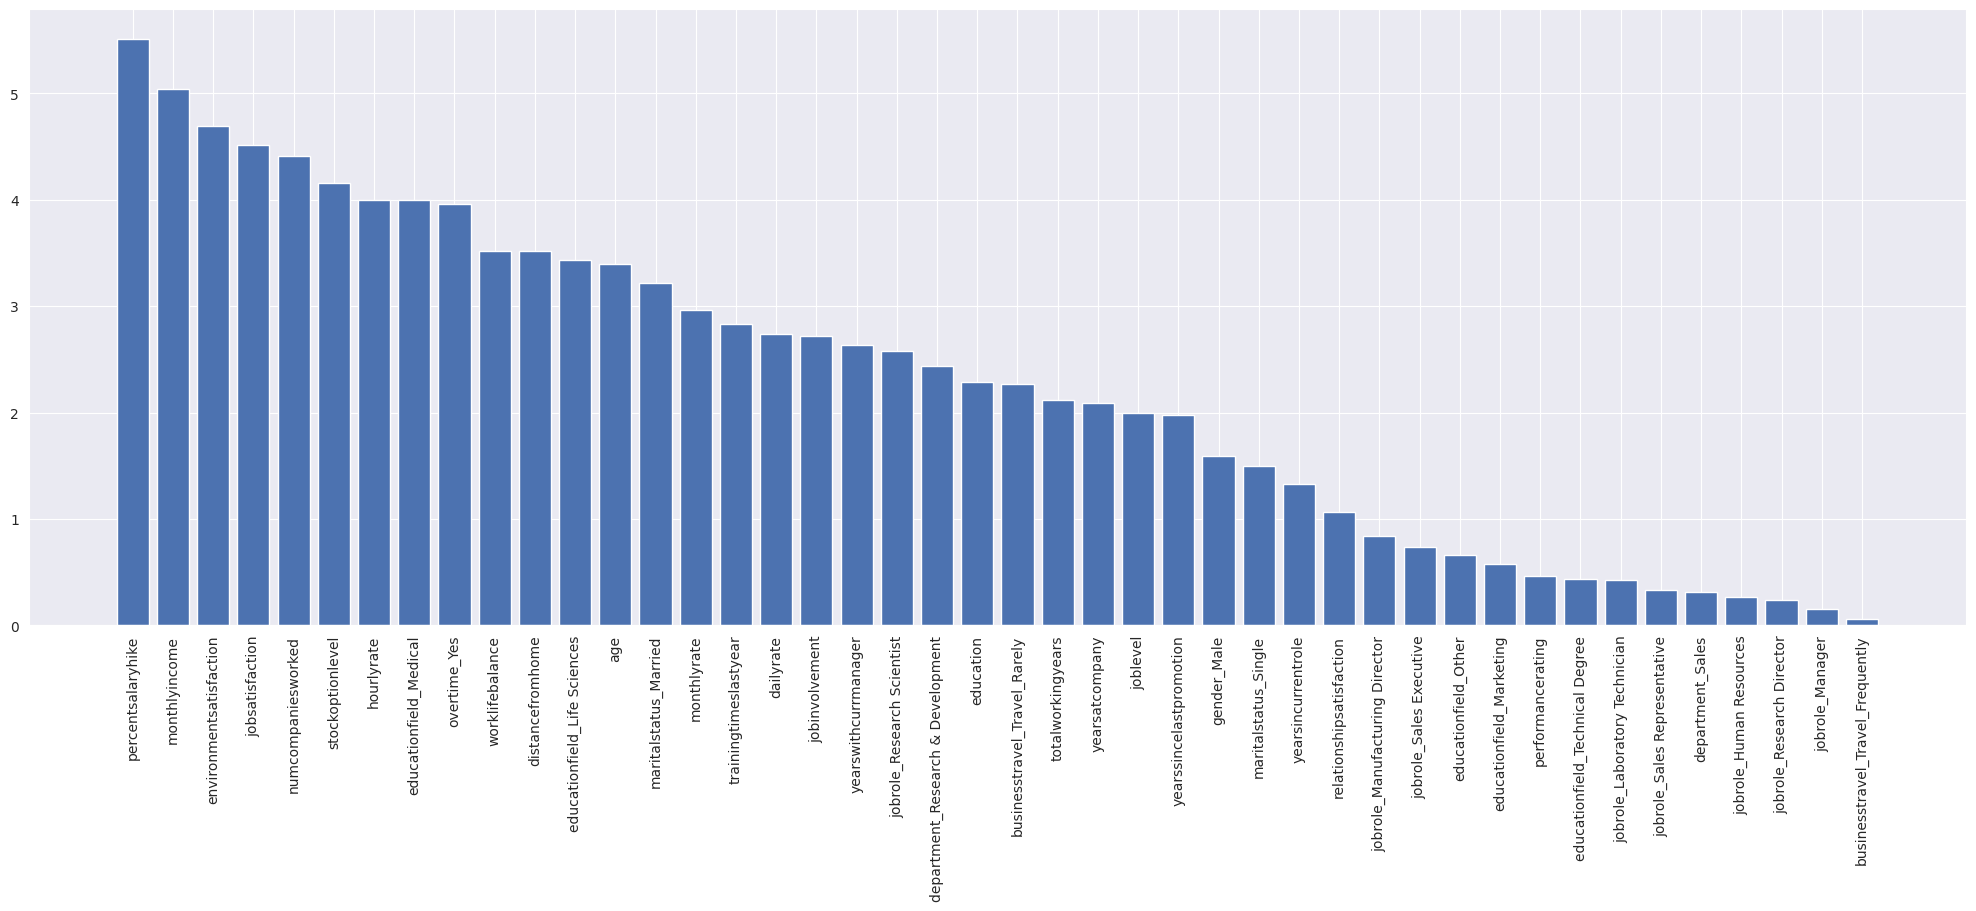

In [54]:
# Show bar plot for feature importance
plt.figure(figsize=(25, 8))
plt.bar(df_feat_imp_sorted.Feature_Name, df_feat_imp_sorted.Importance)
plt.xticks(rotation=90)
plt.show()

In [56]:
# perdict the results for kaggle test file
df_test = pd.read_csv('/content/hr_employee_attrition_test.csv')

In [57]:
const_cols = []
for i in df_test.columns:
    if df_test[i].nunique() == 1:
        const_cols.append(i)

print(const_cols)
df_test.drop(columns=const_cols, axis=1, inplace=True)

['employeecount', 'over18', 'standardhours']


In [58]:
df_test.drop('employeenumber',axis=1, inplace=True)

In [ ]:
# columns_int_to_float =['age','dailyrate','distancefromhome','employeenumber','hourlyrate','monthlyincome', 'monthlyrate']
# # print(columns_int_to_float)
# df_test[columns_int_to_float] = df_test[columns_int_to_float].astype(float)
# # df_test.info()

In [ ]:
# Find categorical columns
# categorical_columns = df_test.select_dtypes(include=['object', 'int']).columns

# # Find numerical columns
# numerical_columns = df_test.select_dtypes(include=['float']).columns

# print("Categorical columns:\n", categorical_columns, len(categorical_columns))
# print()
# print("Numerical columns:\n", numerical_columns, len(numerical_columns))

In [59]:
id = df_test.id
X_test_k = df_test.drop('id', axis=1)

X_test_k.shape

(300, 30)

In [60]:
categorical_features_indices = np.where(X_test_k.dtypes != float)[0]            # np.where will give indices where the condition is True
X_cat_features = X_test_k.columns[categorical_features_indices]

object_features_indices = np.where(X_test_k.dtypes == object)[0]            # np.where will give indices where the condition is True
X_obj_features = X_test_k.columns[object_features_indices]

numeric_features_indices = np.where(X_test_k.dtypes == float)[0]            # np.where will give indices where the condition is True
X_num_features = X_test_k.columns[numeric_features_indices]

X_cat_features, len(X_cat_features), X_obj_features, len(X_obj_features), X_num_features, len(X_num_features)



(Index(['age', 'businesstravel', 'dailyrate', 'department', 'distancefromhome',
        'education', 'educationfield', 'environmentsatisfaction', 'gender',
        'hourlyrate', 'jobinvolvement', 'joblevel', 'jobrole',
        'jobsatisfaction', 'maritalstatus', 'monthlyincome', 'monthlyrate',
        'numcompaniesworked', 'overtime', 'percentsalaryhike',
        'performancerating', 'relationshipsatisfaction', 'stockoptionlevel',
        'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
        'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion',
        'yearswithcurrmanager'],
       dtype='object'),
 30,
 Index(['businesstravel', 'department', 'educationfield', 'gender', 'jobrole',
        'maritalstatus', 'overtime'],
       dtype='object'),
 7,
 Index([], dtype='object'),
 0)

In [61]:
X_test_k = pd.get_dummies(X_test_k, columns = X_obj_features, drop_first = True)
X_test_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                300 non-null    int64
 1   dailyrate                          300 non-null    int64
 2   distancefromhome                   300 non-null    int64
 3   education                          300 non-null    int64
 4   environmentsatisfaction            300 non-null    int64
 5   hourlyrate                         300 non-null    int64
 6   jobinvolvement                     300 non-null    int64
 7   joblevel                           300 non-null    int64
 8   jobsatisfaction                    300 non-null    int64
 9   monthlyincome                      300 non-null    int64
 10  monthlyrate                        300 non-null    int64
 11  numcompaniesworked                 300 non-null    int64
 12  percentsalaryhike     

In [ ]:
# X_test_k[X_num_features] = std_scaler.transform(X_test_k[X_num_features])
model

StackingClassifier(estimators=[('CB',
                                <catboost.core.CatBoostClassifier object at 0x78c89bbfe6b0>),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=...
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('LGBM', LGBMClassifier())],
                   final_estimator=LGBMClassifier())

In [62]:
kaggle_pred = model_CB.predict(X_test_k)


In [63]:
data = {'id':id, 'label':kaggle_pred}
df_result = pd.DataFrame(data)
df_result.to_csv("/content/kaggle_test_submit.csv",index= False)

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


In [65]:
# Copy dataframe

df_emp_clean_XGB = df_emp_clean.copy()
df_emp_clean_XGB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       1170 non-null   float64
 1   businesstravel            1170 non-null   object 
 2   dailyrate                 1170 non-null   float64
 3   department                1170 non-null   object 
 4   distancefromhome          1170 non-null   float64
 5   education                 1170 non-null   int64  
 6   educationfield            1170 non-null   object 
 7   environmentsatisfaction   1170 non-null   int64  
 8   gender                    1170 non-null   object 
 9   hourlyrate                1170 non-null   float64
 10  jobinvolvement            1170 non-null   int64  
 11  joblevel                  1170 non-null   int64  
 12  jobrole                   1170 non-null   object 
 13  jobsatisfaction           1170 non-null   int64  
 14  maritals

**Hint:** Use pd.get_dummies

In [66]:
# Handling categorical features
# YOUR CODE HERE
categorical_features_indices = np.where(df_emp_clean_XGB.dtypes != float)[0]            # np.where will give indices where the condition is True
X_cat_features = df_emp_clean_XGB.columns[categorical_features_indices]

object_features_indices = np.where(df_emp_clean_XGB.dtypes == object)[0]            # np.where will give indices where the condition is True
X_obj_features = df_emp_clean_XGB.columns[object_features_indices]

numeric_features_indices = np.where(df_emp_clean_XGB.dtypes == float)[0]            # np.where will give indices where the condition is True
X_num_features = df_emp_clean_XGB.columns[numeric_features_indices]

X_cat_features, len(X_cat_features), X_obj_features, len(X_obj_features), X_num_features, len(X_num_features)


(Index(['businesstravel', 'department', 'education', 'educationfield',
        'environmentsatisfaction', 'gender', 'jobinvolvement', 'joblevel',
        'jobrole', 'jobsatisfaction', 'maritalstatus', 'overtime',
        'performancerating', 'relationshipsatisfaction', 'stockoptionlevel',
        'trainingtimeslastyear', 'worklifebalance', 'attrition'],
       dtype='object'),
 18,
 Index(['businesstravel', 'department', 'educationfield', 'gender', 'jobrole',
        'maritalstatus', 'overtime', 'attrition'],
       dtype='object'),
 8,
 Index(['age', 'dailyrate', 'distancefromhome', 'hourlyrate', 'monthlyincome',
        'monthlyrate', 'numcompaniesworked', 'percentsalaryhike',
        'totalworkingyears', 'yearsatcompany', 'yearsincurrentrole',
        'yearssincelastpromotion', 'yearswithcurrmanager'],
       dtype='object'),
 13)

In [67]:
df_emp_clean_XGB.head()

,age,businesstravel,dailyrate,department,distancefromhome,education,educationfield,environmentsatisfaction,gender,hourlyrate,jobinvolvement,joblevel,jobrole,jobsatisfaction,maritalstatus,monthlyincome,monthlyrate,numcompaniesworked,overtime,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,attrition
0,43.0,Travel_Rarely,556.0,Research & Development,14.0,2,Life Sciences,2,Female,83.0,2,2,Manufacturing Director,4,Married,5906.00,20456.25,1.0,No,13.0,3,4,2,10.0,2,2,9.0,7.0,2.75,7.0,No
1,34.0,Travel_Rarely,970.0,Research & Development,8.0,2,Medical,2,Female,83.0,3,2,Healthcare Representative,3,Single,6142.00,8387.50,3.0,No,12.0,3,4,0,10.0,2,3,5.0,2.0,2.75,3.0,No
2,39.0,Travel_Rarely,461.0,Research & Development,14.0,3,Medical,3,Male,83.0,3,1,Research Scientist,1,Single,3904.00,20456.25,1.0,No,13.0,3,1,0,6.0,2,3,5.0,2.0,0.00,3.0,Yes
3,30.0,Travel_Rarely,933.0,Sales,2.0,3,Life Sciences,3,Male,57.0,3,2,Sales Executive,3,Married,5296.00,20156.00,1.0,No,17.0,3,2,1,8.0,3,3,8.0,7.0,2.75,7.0,No
4,40.0,Travel_Rarely,461.0,Research & Development,2.0,4,Life Sciences,2,Male,83.0,3,1,Laboratory Technician,2,Married,2914.75,8387.50,3.0,No,18.0,4,3,1,7.0,3,3,4.0,2.0,0.00,3.0,No


In [68]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
df_emp_clean_XGB = pd.get_dummies(df_emp_clean_XGB, columns = X_obj_features, drop_first = True)


In [ ]:
df_emp_clean_XGB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1170 entries, 0 to 1169
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                1170 non-null   float64
 1   dailyrate                          1170 non-null   float64
 2   distancefromhome                   1170 non-null   float64
 3   education                          1170 non-null   int64  
 4   environmentsatisfaction            1170 non-null   int64  
 5   hourlyrate                         1170 non-null   float64
 6   jobinvolvement                     1170 non-null   int64  
 7   joblevel                           1170 non-null   int64  
 8   jobsatisfaction                    1170 non-null   int64  
 9   monthlyincome                      1170 non-null   float64
 10  monthlyrate                        1170 non-null   float64
 11  numcompaniesworked                 1170 non-null   float

In [69]:
# Rename target column
df_emp_clean_XGB.rename(columns={'attrition_Yes': 'attrition'}, inplace=True)

In [70]:
df_emp_clean_XGB.head()

,age,dailyrate,distancefromhome,education,environmentsatisfaction,hourlyrate,jobinvolvement,joblevel,jobsatisfaction,monthlyincome,monthlyrate,numcompaniesworked,percentsalaryhike,performancerating,relationshipsatisfaction,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsatcompany,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,gender_Male,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,maritalstatus_Married,maritalstatus_Single,overtime_Yes,attrition
0,43.0,556.0,14.0,2,2,83.0,2,2,4,5906.00,20456.25,1.0,13.0,3,4,2,10.0,2,2,9.0,7.0,2.75,7.0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
1,34.0,970.0,8.0,2,2,83.0,3,2,3,6142.00,8387.50,3.0,12.0,3,4,0,10.0,2,3,5.0,2.0,2.75,3.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,39.0,461.0,14.0,3,3,83.0,3,1,1,3904.00,20456.25,1.0,13.0,3,1,0,6.0,2,3,5.0,2.0,0.00,3.0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1
3,30.0,933.0,2.0,3,3,57.0,3,2,3,5296.00,20156.00,1.0,17.0,3,2,1,8.0,3,3,8.0,7.0,2.75,7.0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,40.0,461.0,2.0,4,2,83.0,3,1,2,2914.75,8387.50,3.0,18.0,4,3,1,7.0,3,3,4.0,2.0,0.00,3.0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0


In [71]:
# Feature Space
X = df_emp_clean_XGB.drop('attrition', axis=1)

# Targer label
y = df_emp_clean_XGB['attrition']

X.shape, y.shape

((1170, 44), (1170,))

In [72]:
# le3 = LabelEncoder()
# le3.fit(y)
# y_transformed = le3.transform(y)
y

0       0
1       0
2       1
3       0
4       0
       ..
1165    0
1166    0
1167    0
1168    0
1169    0
Name: attrition, Length: 1170, dtype: uint8

In [73]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.20, random_state = 42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1569, 44), (1569,), (393, 44), (393,))

### Model Definition

In [75]:
# Create XGBoost classifier model
best_params_xgb = {'n_estimators': 17, 'max_depth': 5, 'gamma': 0.5035491022061518, 'learning_rate': 0.2992696504089018}

XGB_clf = XGBClassifier(
                        # objective = 'multi:softmax',
                        # num_class = 3,
                        # booster = 'gbtree',
                        learning_rate = best_params_xgb['learning_rate'],
                        max_depth = best_params_xgb['max_depth'],
                        # # scale_pos_weight = 24,
                        # # scale_pos_weight = 1,
                        gamma = best_params_xgb['gamma'],
                        n_estimators=best_params_xgb['n_estimators'],
                        # # min_child_weight=1,
                        # # subsample=0.8,
                        # # colsample_bytree=0.8,
                        # # objective= 'binary:logistic'
                        )

In [76]:
# Model training
# YOUR CODE HERE
XGB_clf.fit(X_train,y_train,
            eval_set = [(X_train, y_train), (X_test, y_test)],
            verbose = False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5035491022061518, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2992696504089018, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=17, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Model Performance

In [77]:
# Model performance on all sets
XGB_prediction = XGB_clf.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, XGB_prediction))
model = XGB_clf

Accuracy Score:  0.9033078880407125


In [78]:
print('Classification Report for XGBoostClassifier:')
print(classification_report(y_test, XGB_prediction))

Classification Report for XGBoostClassifier:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       186
           1       0.94      0.87      0.90       207

    accuracy                           0.90       393
   macro avg       0.90      0.90      0.90       393
weighted avg       0.91      0.90      0.90       393



In [ ]:
!pip install --quiet optuna


In [ ]:
import optuna
optuna.__version__

In [ ]:

def objective(trial):
    # Define hyperparameter search space
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 2, 20),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        # 'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 1),
        # 'subsample': trial.suggest_float('subsample', 0.1, 1),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    }

    # Create and fit the XGBoost classifier
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=100)  # you can adjust n_trials

# Get the best hyperparameters
best_params = study.best_params
print(f"Best params {best_params}")
# best_learning_rate = best_params['learning_rate']
# print(f'Best Learning Rate: {best_learning_rate:.4f}')

# Train the final model with the best hyperparameters
final_model = XGBClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_final = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f'Final Accuracy: {final_accuracy:.2f}')


In [ ]:
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

# weights = [1, 2, 3, 4, 5, 24, 25, 26]
# param_grid = dict(scale_pos_weight=weights)

# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

# # execute the grid search
# grid_result = grid.fit(X, y_transformed)

# # report the best configuration
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# # report all configurations

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


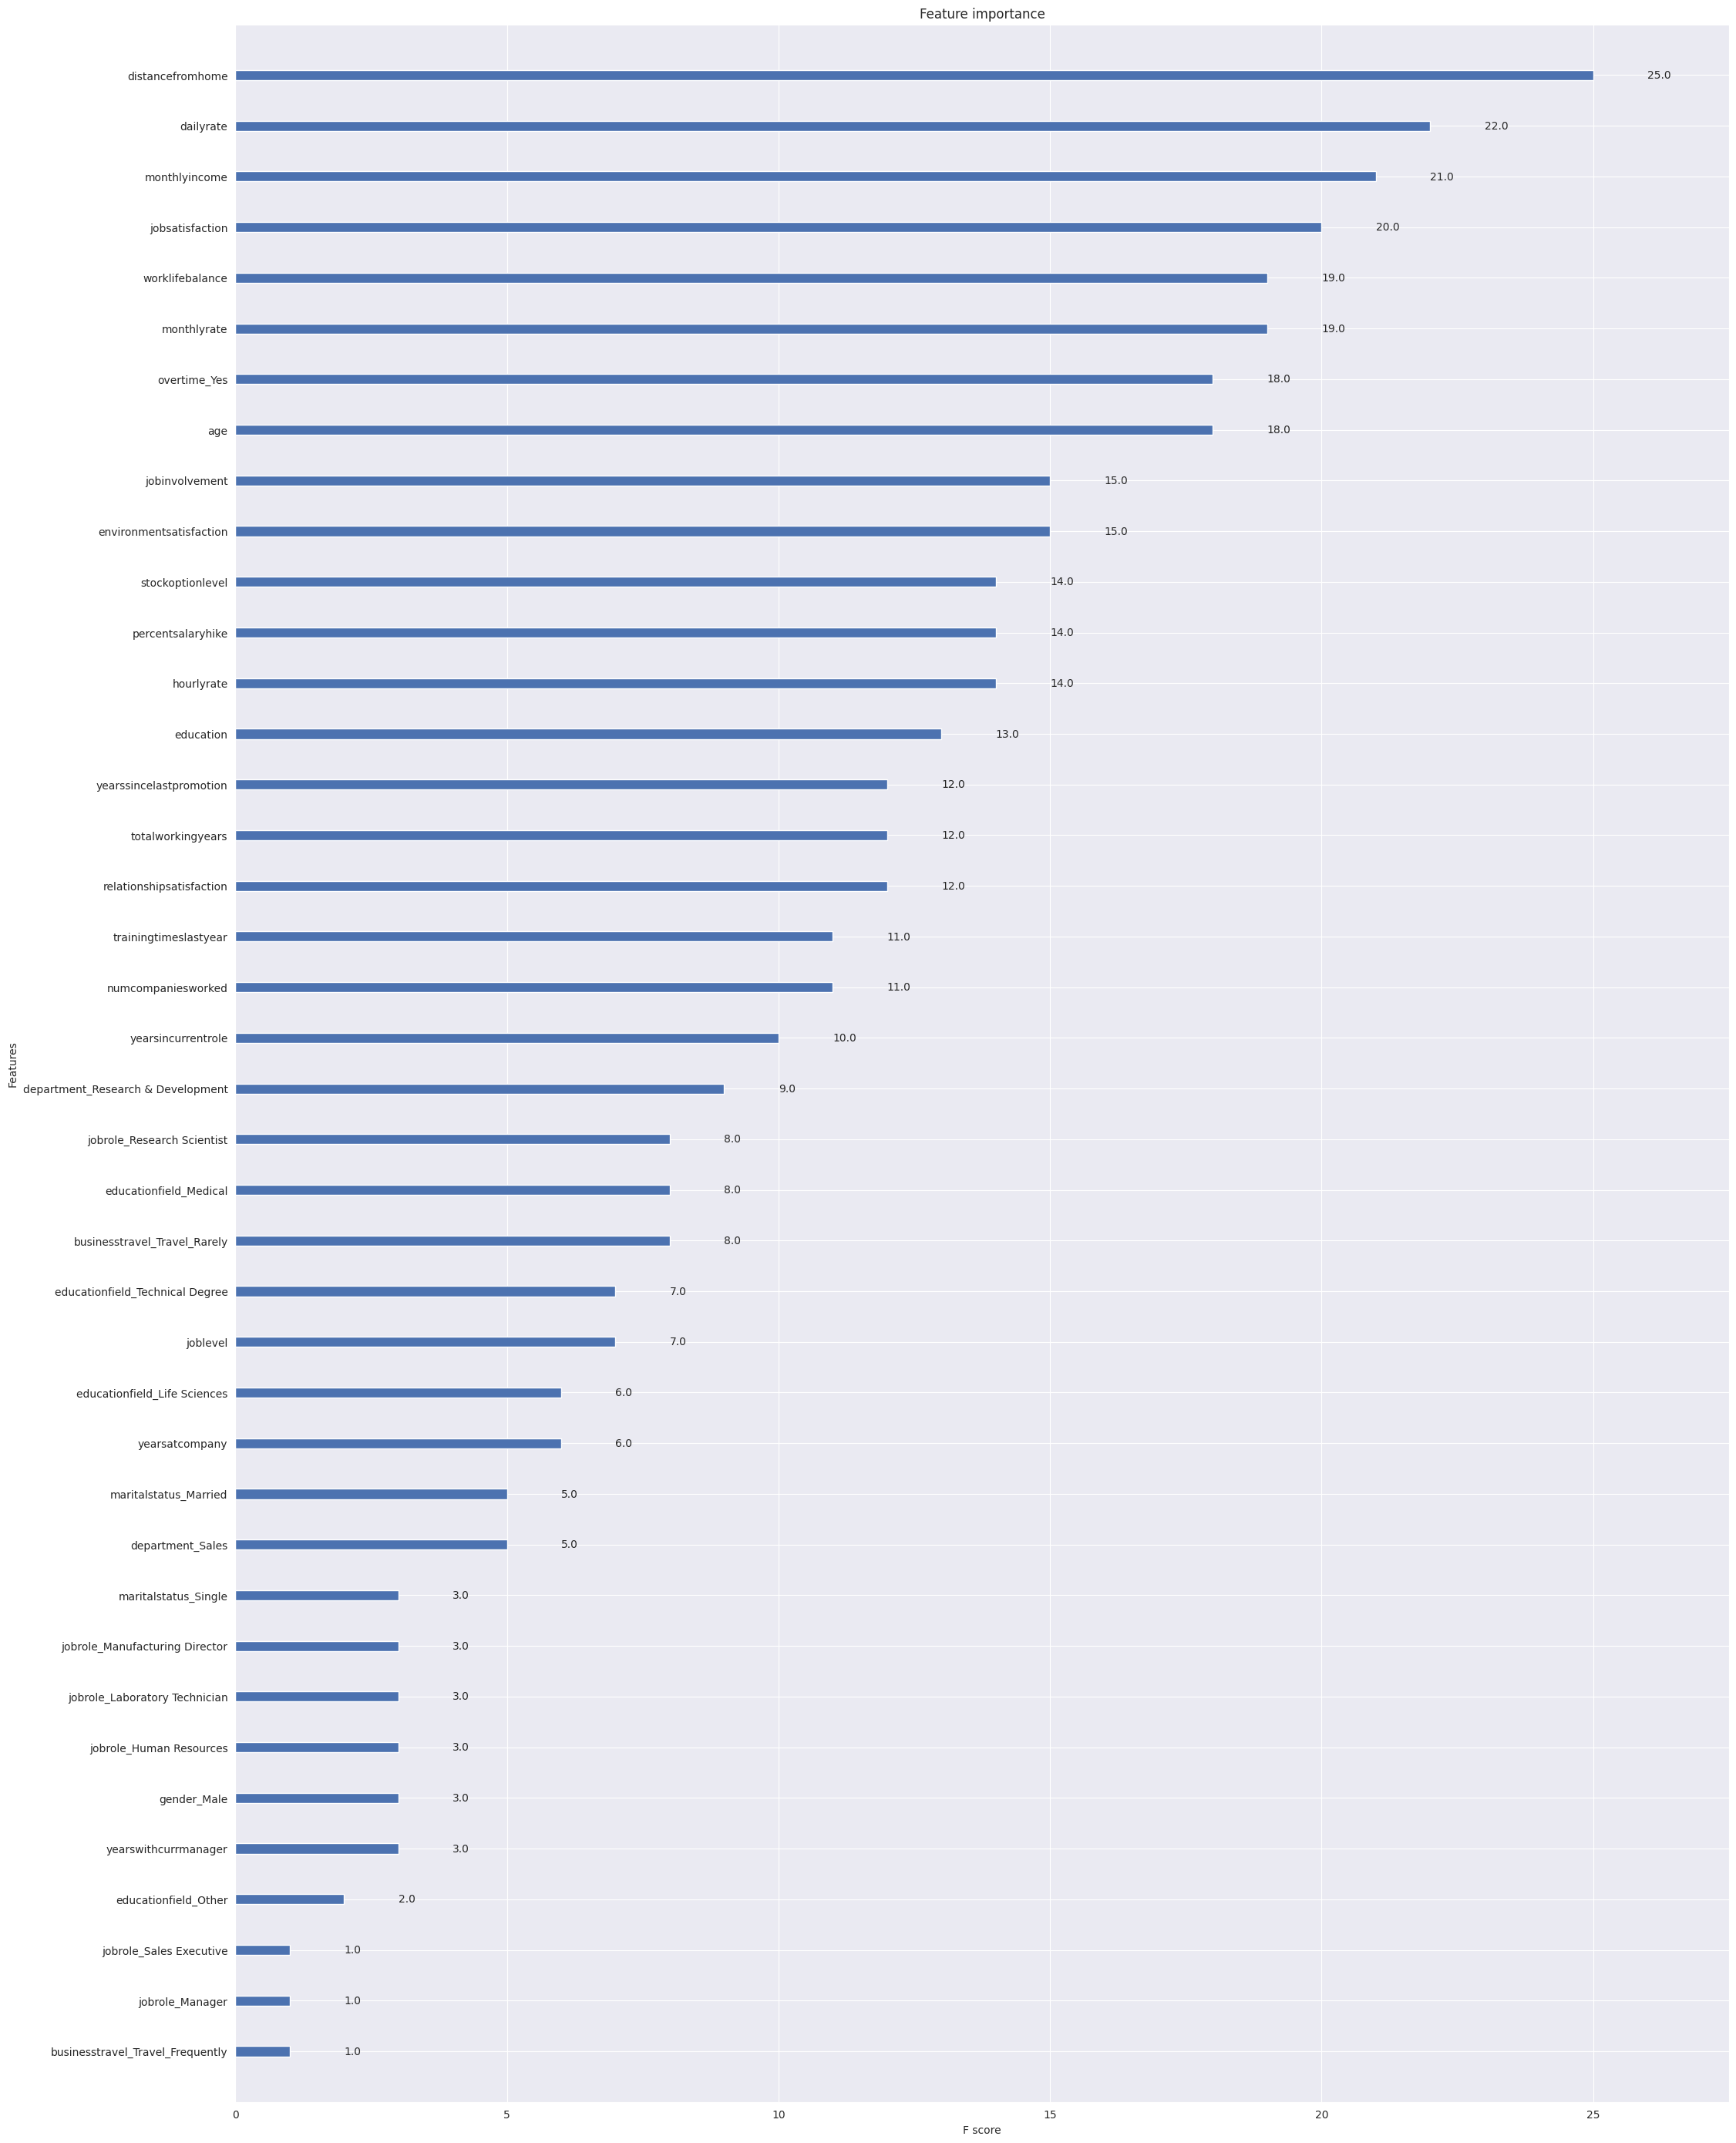

In [80]:
import xgboost as xgb
xgb.plot_importance(XGB_clf)
plt.rcParams['figure.figsize'] = [25, 35]
plt.show()

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [81]:
## Following the same procedure as followed in XGBoost



In [82]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1569, 44), (1569,), (393, 44), (393,))

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [83]:
# Create LightGBM classifier model
# YOUR CODE HERE
best_params_lgbm = {'n_estimators': 470, 'learning_rate': 0.06539139101622277, 'num_leaves': 76, 'min_child_samples': 15}
LGBM_clf = LGBMClassifier(
                          n_estimators = best_params_lgbm['n_estimators'],
                          learning_rate = best_params_lgbm['learning_rate'],
                          num_leaves = best_params_lgbm['num_leaves'],
                          # min_child_samples = best_params_lgbm['min_child_samples'],
                          verbose = -1
                          )

In [85]:
# Model training
# YOUR CODE HERE
LGBM_clf.fit(X_train,y_train,
             eval_set = [(X_train, y_train), (X_test, y_test)])

LGBMClassifier(learning_rate=0.06539139101622277, n_estimators=470,
               num_leaves=76, verbose=-1)

### Model performance

In [86]:
# Model performance on all sets
# YOUR CODE HERE
LGBM_prediction = LGBM_clf.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, LGBM_prediction))
model = LGBM_clf

Accuracy Score:  0.9312977099236641


In [87]:
print('Classification Report for LGBM:')
print(classification_report(y_test, LGBM_prediction))

Classification Report for LGBM:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       186
           1       0.97      0.90      0.93       207

    accuracy                           0.93       393
   macro avg       0.93      0.93      0.93       393
weighted avg       0.93      0.93      0.93       393



In [ ]:

def objective(trial):
    # Define hyperparameter search space
    # Define a study space for hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 1.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        # 'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
    }

    # Initialize and train the LGBMClassifier with the suggested hyperparameters
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy as the objective to optimize
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')  # maximize accuracy
study.optimize(objective, n_trials=100)  # you can adjust n_trials

# Get the best hyperparameters
best_params = study.best_params
print(f"Best params {best_params}")
# best_learning_rate = best_params['learning_rate']
# print(f'Best Learning Rate: {best_learning_rate:.4f}')

# Train the final model with the best hyperparameters
final_model = LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred_final = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f'Final Accuracy: {final_accuracy:.2f}')


In [ ]:
print(f"Best params {best_params}")

Best params {'n_estimators': 470, 'learning_rate': 0.06539139101622277, 'num_leaves': 76, 'min_child_samples': 15}


In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import VotingClassifier

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier

# Instantiate LogisticRegression, KNN, SVC and VotingClassifier
n_neighbors = 1
knn_clf = KNN(n_neighbors)
sm_clf = LogisticRegression(
                            #  multi_class='multinomial', # switch to Softmax Regression
                             solver='newton-cg', # handle multinomial loss, L2 penalty
                             C=1
                            )

# svm_clf = SVC(probability= True, kernel='poly', gamma=0.1, C=1)
svm_clf = SVC(probability=True, kernel='rbf', C=1000, random_state=42)

dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier( base_estimator=dt_clf,     # base estimator to fit on random subsets of the dataset
                            n_estimators=300,       # number of base estimators in the ensemble
                            max_samples=300,        # number of samples to draw from X to train each base estimator.
                                                    # If int, then draw max_samples samples.
                                                    # If float, then draw (max_samples * X.shape[0]) samples.
                            bootstrap=True,         # whether samples are drawn with replacement
                            random_state= 42       # seed used by the random number generator to ensure reproducibility
                            )

rf_clf = RandomForestClassifier(n_estimators=300,           # number of trees in the forest
                                # max_leaf_nodes=16,          # grow trees with max_leaf_nodes, selected by
                                                            # relative reduction in impurity.
                                                            # If None, then unlimited number of leaf nodes
                                random_state= 42
                                )


classifiers = [('knn', knn_clf), ('svc', svm_clf), ('dt_bag',bag_clf), ('rf',rf_clf), ('sm',sm_clf), ('CB',model_CB), ('XGB',XGB_clf), ('LGBM',LGBM_clf)]
# classifiers = [('knn', knn_clf), ('dt_bag',bag_clf), ('rf',rf_clf), ('sm',sm_clf), ('CB',model_CB), ('XGB',XGB_clf), ('LGBM',LGBM_clf)]
# classifiers = [('rf',rf_clf), ('sm',sm_clf), ('CB',model_CB), ('XGB',XGB_clf), ('LGBM',LGBM_clf)]

voting_clf = VotingClassifier(estimators= classifiers, voting='soft')

for model in (knn_clf, sm_clf, svm_clf, bag_clf, rf_clf, model_CB, XGB_clf, LGBM_clf, voting_clf):
# for model in (knn_clf, sm_clf, bag_clf, rf_clf, model_CB, XGB_clf, LGBM_clf, voting_clf):
# for model in (bag_clf, rf_clf, model_CB, XGB_clf, LGBM_clf, voting_clf):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__, accuracy_score(y_test, y_pred))



KNeighborsClassifier 0.7557251908396947
LogisticRegression 0.8931297709923665
SVC 0.6234096692111959
BaggingClassifier 0.9083969465648855
RandomForestClassifier 0.9083969465648855
CatBoostClassifier 0.9211195928753181
XGBClassifier 0.9033078880407125
LGBMClassifier 0.9312977099236641
VotingClassifier 0.9236641221374046


In [92]:
model

StackingClassifier(estimators=[('CB',
                                <catboost.core.CatBoostClassifier object at 0x7b6cb87b6ad0>),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None,
                                              gamma=0.5035491022061518,
                                              gpu_id=Non...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=5,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=17, n_jobs=None,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('LGBM',
                                LGBMClassifier(learning_rate=0.06539139101622277,
                                               n_estimators=470, num_leaves=76,
                                               verbose=-1))],
                   final_estimator=LGBMClassifier())

In [91]:
fin_classifier = LGBMClassifier()
# estimators = [('knn', knn_clf), ('svc', svm_clf), ('dt_bag',bag_clf), ('rf',rf_clf), ('sm',sm_clf), ('CB',model_CB), ('XGB',XGB_clf), ('LGBM',LGBM_clf)]
estimators = [('CB',model_CB), ('XGB',XGB_clf), ('LGBM',LGBM_clf)]
model = StackingClassifier(estimators=estimators,final_estimator=fin_classifier)
# fit the model
model.fit(X_train,y_train)
pred = model.predict(X_test)
accuracy_score(y_test, pred)
# model

[LightGBM] [Info] Number of positive: 774, number of negative: 795
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 1569, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.493308 -> initscore=-0.026770
[LightGBM] [Info] Start training from score -0.026770


0.916030534351145

## Results

**Hint:** Use pd.DataFrame

In [ ]:
# Create a dataframe for computed metrics for different models


Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/